# Задача:

Дано изображение с объектом, который находится в неправильной ориентации. Необходимо найти число x, такое, что если повернуть изображение по часовой стрелке на x*(360/7) градусов, объект встанет в правильную ориентацию.

Общая структура проекта:

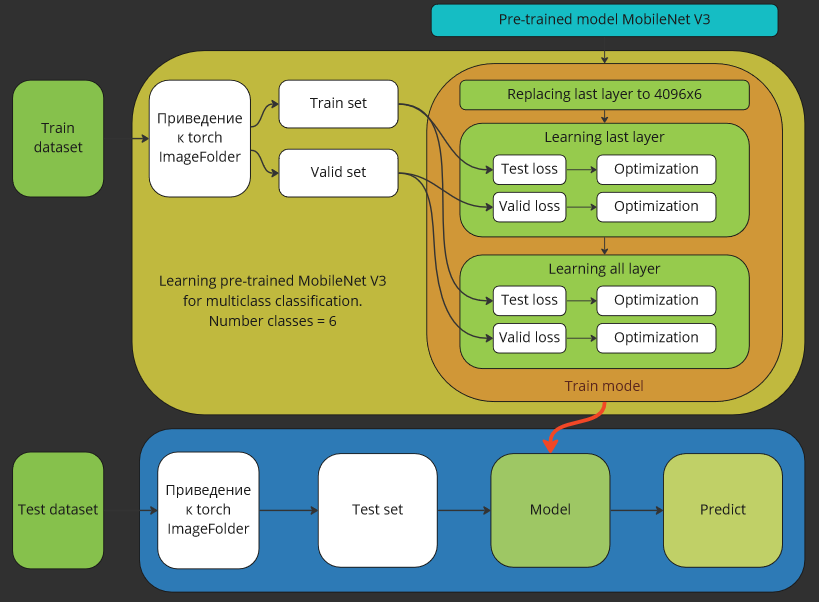

## Решение
1. Данные предоставлены в виде папок Funcaptcha7 и Test. Папка Funcaptcha7 содержит в себе 22 подпапки. В каждой из подпапок находятся картинки случайных классов. <br> 
Для простоты обработки изображений по классам, изображения приведены к виду torch ImageFolder.
2. Далее разбил тренировочные данные на trail и valid (80 и 20 % соотв.). К тренировочной выборке применена аугментация: ЧБ с 3 каналами, размер 110х110, Blur, случайное аффинное преобразование: поворот -5:5 град, изм. размера на 0.5:1.5, сдвиг от -20 до 20% от размера изображения, растяжение от -20 до 20 град. <br>
Валидационные и тестовые данные переведены в ЧБ (3 канала), обрезан размер (110х110).
3. В качестве предобученных моделей, пробовались: 
* AlexNet, 
* MobileNet V3 (small), 
* EfficientNet B0. <br><br>
У моделей замораживались все слои, менялся последний с количеством выхода = количеству классов. Каждая модель обучалась 1 эпоху, все слои размораживались и модель обучалась ещё 5 эпох. <br>
В результате, лучше всего себя показала модель MobileNet V3 (small).

4. В процессе обучения высчитывылись заданные метрики, после обучения, проводится проверка на тестовом наборе.

## Результат
В результате работы, точность на тестовом наборе данных составляет 39%, средняя ошибка = 0.01, что равно 0.5 градусам.
Результат можно улучшить, сближением тренировочной и тестовой выборок.
<br><br><br>
Возможные ошибки:
* При выполнении в colab, может повисать функция распаковки 7z, лечится повторным запуском функции и пропуском существующих файлов.
* В colab, при работе с google drive, могут быть сложности с синхронизацией файлов с диском. Помогает перезапуск удаленной среды.
* При первом запуске colab, долго загружаются изображения с диска, при обучении первого слоя.

##### Автор
Максимов Сергей<br>
cehkop@gmail.com

# Pre-processing

In [2]:
#@title Import lib

import os, shutil
import glob
from collections import Counter
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image, ImageDraw

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [3]:
#@title Basic var

# some of basic var

dirToFuncaptcha7 = r'funcaptcha7'
dirTrainDataset = r'dataset/'
dirTestDatasetOld = r'test/test_set'
dirTestDatasetNew = r'testByClass/'


# Type of device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Batch size
batch_size = 64

In [ ]:
#@title Unzip .7z, if need
# !7z x path_to.7z -o/path_to_new_dir
# 
# !7z x /content/drive/MyDrive/ZennoLabsTest/funcaptcha7.7z -o/content/drive/MyDrive/ZennoLabsTest/

In [4]:
#@title Reduction train data to the form torch ImageFolder

# Set for classes name
classOfImgSet = set()

# For every X.txt file in subfolder of 'dirToFuncaptcha7',
# read class in file, check it isn't used,
# if not used, make new folder for this class.
# Then move X.png 'dirTrainDataset + class'.
number = 0
for nameOfFile in glob.glob(os.path.join(dirToFuncaptcha7, '**/*.txt')):
    with open(nameOfFile, 'r') as in_f:
        classOfImg = in_f.read()
        if classOfImg not in classOfImgSet:
            os.makedirs((dirTrainDataset + classOfImg), exist_ok=True)
            classOfImgSet.add(classOfImg)

        namePng = nameOfFile[:-4] + '.png'
        if os.path.exists(namePng):
            shutil.move(namePng, (dirTrainDataset + classOfImg + '/' + str(number) + '.png'))

            if (number % 2000) == 0:
                print(f'Count preproc img = {number}')
            number += 1
            
print('Train dataset was sort by the class')

Count preproc img = 0
Count preproc img = 2000
Count preproc img = 4000
Count preproc img = 6000
Count preproc img = 8000
Count preproc img = 10000
Count preproc img = 12000
Count preproc img = 14000
Count preproc img = 16000
Count preproc img = 18000
Count preproc img = 20000
Train dataset was sort by the class


In [5]:
#@title Make train data loader and augmentations 

# Applying Transforms to the Data
img_transforms = {
    "train": transforms.Compose(
        [
            transforms.Grayscale(3),
            transforms.Resize(size=(110, 110)),
            transforms.GaussianBlur(kernel_size=5, sigma=(1e-4,50)),
            transforms.RandomAffine(degrees=(-5, 5), # rotate
                                    scale = (0.5, 1.5), # zoom
                                    shear = (-20, 20, -20, 20), # shift
                                    translate = (0.15, 0.15)), # stretch
            transforms.ToTensor(),
        ]
    ),
    "valid": transforms.Compose( 
        [
            transforms.Grayscale(3),
            transforms.Resize(size=(110, 110)),
            transforms.ToTensor(),
        ]
    ),
}

dataset = datasets.ImageFolder(root=dirTrainDataset)

# split to train/valid/test
train_set, valid_set = torch.utils.data.random_split(dataset, 
                                                     [round(len(dataset)*0.80), 
                                                      round(len(dataset)*0.2)]
                                                    )

# # define augmentations
train_set.dataset.transform = img_transforms['train']
valid_set.dataset.transform = img_transforms['valid']

# Create iterators for the Data loaded using DataLoader module
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size, valid_data_size = len(train_set), len(valid_set)

#number of classes
num_classes = len(dataset.classes)

# Get a mapping of the indices to the class names, 
# in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

print(f'Train size: {train_data_size}')
print(f'Valid size: {valid_data_size}')
print(f'Number of classes: {num_classes}')
print(f'Number per classes: \n\t{dict(Counter(dataset.targets))}')

Train size: 17600
Valid size: 4400
Number of classes: 6
Number per classes: 
	{0: 3635, 1: 3575, 2: 3795, 3: 3669, 4: 3740, 5: 3586}


In [6]:
#@title Reduction test data to the form torch ImageFolder

# Set for classes name
classOfImgSetTest = set()
number = 0

# For every X.txt file in subfolder of dirToFuncaptcha7
# read class in file, check it isn't used
# if not used, make new folder for this class.
# Take the file X.png and remove to dirTrainDataset + class.
# File X.txt keep stay in dirToFuncaptcha7.

for nameOfFile in glob.glob(os.path.join(dirTestDatasetOld, '*.txt')):
    with open(nameOfFile, 'r') as in_f:
        classOfImg = in_f.read()
        # If this class doesn't exist, choose random class
        if classOfImg not in dataset.class_to_idx:
            classOfImg = str(random.choice(list(dataset.class_to_idx.values())))
        # Make new dir
        if classOfImg not in classOfImgSetTest:
            os.makedirs((dirTestDatasetNew + classOfImg), exist_ok=True)
            classOfImgSetTest.add(classOfImg)
        # Take .png file and move to dirTestDatasetNew + classOfImg folder
        namePng = nameOfFile[:-4] + '.png'
        if os.path.exists(namePng):
            shutil.move(namePng, (dirTestDatasetNew + classOfImg + '/' + str(number) + '.png'))
            number += 1
            
print('Test dataset was sort by the class')

Test dataset was sort by the class


In [7]:
#@title Make test data loader and augmentations

img_transforms = {
        # No augmentations on test data!
        "test": transforms.Compose(
            [
                transforms.Grayscale(3),
                transforms.Resize(size=110),
                transforms.ToTensor(),
            ]
        )
    }

test_set = datasets.ImageFolder(root=dirTestDatasetNew)

test_loader = torch.utils.data.DataLoader(test_set, 
                                            batch_size=batch_size,
                                            shuffle=False)

test_loader.dataset.transform = img_transforms['test']

# Learning model

In [8]:
#@title Function of learning

def train_and_validate(model, criterion, optimizer, num_epochs=25, save_state=False):
    """
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    """

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        train_correct = 0
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()  
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)  
            # Compute loss
            loss = criterion(outputs, labels)  
            # Backpropagate the gradients
            loss.backward() 
            # Update the parameters
            optimizer.step()  

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            # Compute correct predictions
            train_correct += (torch.argmax(outputs, dim=-1) == labels).float().sum()

        # Compute the mean train accuracy
        train_accuracy = 100 * train_correct / (len(train_loader) * batch_size)

        val_correct = 0
        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()  # Set to evaluation mode

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)  
                # Compute loss
                loss = criterion(outputs, labels)  
                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)  

                val_correct += (torch.argmax(outputs, dim=-1) == labels).float().sum()

        # Compute mean val accuracy       
        val_accuracy = 100 * val_correct / (len(valid_loader) * batch_size)

        # Find average training loss and training accuracy
        avg_train_loss = train_loss / (len(train_loader) * batch_size)

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss / (len(valid_loader) * batch_size)

        history.append([avg_train_loss, 
                        avg_valid_loss,
                        train_accuracy.detach().cpu(), 
                        val_accuracy.detach().cpu()])

        epoch_end = time.time()

        print(
            "Epoch : {:03d}, \tTraining: Loss: {:.4f}, Accuracy: {:.4f}%, \n \
            \t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s"\
            .format(
                epoch + 1,
                avg_train_loss,
                train_accuracy.detach().cpu(),
                avg_valid_loss,
                val_accuracy.detach().cpu(),
                epoch_end - epoch_start,
            )
        )

    return model, history


def check_predictions():
    # total and correct predicted counter
    correct = 0
    total = 0
    # Set to evaluation mode
    trained_model.eval()

    # list of (predicted - labels)
    listOfPred = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = trained_model(images).to(device)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            
            predicted = predicted.squeeze().tolist()
            labels = labels.squeeze().tolist()

            # Calc accuracy and mean_error
            for i, pred in enumerate(predicted):
                total += 1
                diff = pred - labels[i]
                if not diff:
                    correct += 1
                listOfPred.append(diff)

    recall = (100 * correct // total)
    recall_mean = np.mean(listOfPred)
    
    return recall, recall_mean

In [9]:
#@title Learning model

model = models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.DEFAULT')

# Freeze all layer
for param in model.parameters():
    param.requires_grad = False
# Change the final layer of model for Transfer Learning
model.classifier[3] = nn.Linear(1024, 6)

# choose criterion and optimzer. Criterion = CrossEntropy, so, we don't LogSoft
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train last layer
trained_model, history = train_and_validate(model.to(device), 
                                            criterion, 
                                            optimizer, 
                                            num_epochs = 1
                                           )
# Unreeze all layer
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=3e-5)
# Train all layer
trained_model, history = train_and_validate(model.to(device), 
                                            criterion, 
                                            optimizer, 
                                            num_epochs = 5
                                           )


accuracy, mean_error = check_predictions()
print()
print(f'Accuracy on test data: {accuracy}%')
print(f"Mean error of angle = {mean_error}, it's equal {mean_error*360/7:.1f} degrees")
print(f'Accuracy on validation data = {history[-1][-1].tolist():.3f}%')
print(f'Accuracy on train data = {history[-1][-2].tolist():.3f}%')

Epoch: 1/1
Epoch : 001, 	Training: Loss: 1.6145, Accuracy: 36.6364%, 
             		Validation : Loss : 1.6240, Accuracy: 34.5788%, Time: 119.2375s
Epoch: 1/5
Epoch : 001, 	Training: Loss: 0.8323, Accuracy: 75.7784%, 
             		Validation : Loss : 0.6874, Accuracy: 74.0036%, Time: 302.8273s
Epoch: 2/5
Epoch : 002, 	Training: Loss: 0.2416, Accuracy: 93.1761%, 
             		Validation : Loss : 0.2432, Accuracy: 91.8478%, Time: 277.9784s
Epoch: 3/5
Epoch : 003, 	Training: Loss: 0.1088, Accuracy: 96.8580%, 
             		Validation : Loss : 0.0793, Accuracy: 97.2373%, Time: 250.2483s
Epoch: 4/5
Epoch : 004, 	Training: Loss: 0.0602, Accuracy: 98.3409%, 
             		Validation : Loss : 0.0521, Accuracy: 98.0299%, Time: 238.0020s
Epoch: 5/5
Epoch : 005, 	Training: Loss: 0.0363, Accuracy: 99.0455%, 
             		Validation : Loss : 0.0582, Accuracy: 97.5091%, Time: 238.4346s

Accuracy on test data: 39%
Mean error of angle = 0.01, it's equal 0.5 degrees
Accuracy on validation data